# Nasscom project 18BIT0313


In [37]:
%matplotlib inline

In [2]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix


In [3]:
weather = pd.read_csv("Train_Test_IOT_Weather.csv")

In [4]:
weather.head()

,ts,date,time,temperature,pressure,humidity,label,type
0,1556238796,25-Apr-19,17:33:16,40.881866,-0.101806,38.363631,1,ddos
1,1556238796,25-Apr-19,17:33:16,44.913806,2.661616,46.141423,1,ddos
2,1556238796,25-Apr-19,17:33:16,38.295822,-2.438871,50.850643,1,ddos
3,1556238801,25-Apr-19,17:33:21,41.306586,-0.101806,38.363631,1,ddos
4,1556238801,25-Apr-19,17:33:21,44.903178,3.080849,46.141423,1,ddos


In [5]:
weather.drop(columns=['date','time','ts','label'],inplace=True)

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59260 entries, 0 to 59259
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  59260 non-null  float64
 1   pressure     59260 non-null  float64
 2   humidity     59260 non-null  float64
 3   type         59260 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.8+ MB


In [7]:
weather['type'].value_counts()

normal        35000
password       5000
backdoor       5000
injection      5000
ddos           5000
ransomware     2865
xss             866
scanning        529
Name: type, dtype: int64

In [8]:
weather.describe()

,temperature,pressure,humidity
count,59260.000000,59260.000000,59260.000000
mean,35.378616,0.892187,48.729767
std,8.332903,2.787494,28.550055
min,20.527012,-12.065426,0.278928
25%,28.209857,0.188713,23.488462
50%,35.773605,1.035000,46.343618
75%,42.243863,1.787000,74.532262
max,50.000000,12.487613,99.875982


In [38]:
weather

,temperature,pressure,humidity,type
5865,30.168667,8.891470,95.681530,1
55274,40.525911,-1.272387,40.383435,3
16940,33.837622,5.910876,22.791873,2
50116,22.185027,0.640275,20.763539,3
8638,34.749586,1.862918,48.347544,3
...,...,...,...,...
52321,26.840390,-0.295382,32.602676,3
43692,27.004156,1.256507,21.273527,3
21327,21.582290,3.976910,56.834003,4
31125,24.983843,1.051005,25.140289,3


In [9]:
label_type=LabelEncoder()
weather['type']=label_type.fit_transform(weather['type'])

In [10]:
weather['type'].value_counts()

3    35000
4     5000
2     5000
1     5000
0     5000
5     2865
7      866
6      529
Name: type, dtype: int64

In [11]:
## Splitting the data
train_set, test_set = train_test_split(weather, test_size=0.2, random_state=42)
print(f"train: {len(train_set)}\ntest: {len(test_set)}")
## This will not give even distribution of types which may cause issues if one type is not available

train: 47408
test: 11852


In [12]:
train_set['type'].value_counts()

3    27949
2     4025
4     4021
1     4016
0     3997
5     2297
7      687
6      416
Name: type, dtype: int64

In [13]:
test_set['type'].value_counts()

3    7051
0    1003
1     984
4     979
2     975
5     568
7     179
6     113
Name: type, dtype: int64

In [14]:
## All types are available but we will perform StratifiedShuffleSplit to improve probability of correct detection
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(weather, weather['type']):
    strat_train = weather.loc[train_index]
    strat_test = weather.loc[test_index]

In [15]:
strat_train['type'].value_counts()

3    28000
4     4000
2     4000
1     4000
0     4000
5     2292
7      693
6      423
Name: type, dtype: int64

In [16]:
strat_test['type'].value_counts()

3    7000
4    1000
2    1000
1    1000
0    1000
5     573
7     173
6     106
Name: type, dtype: int64

In [17]:
## Use training data to train
weather = strat_train.copy()

In [18]:
corr_matrix = weather.corr()

In [19]:
corr_matrix['type'].sort_values(ascending=False)
##Low correlations

type           1.000000
pressure       0.138103
temperature   -0.133273
humidity      -0.187966
Name: type, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDEFB24D08>,
      dtype=object)

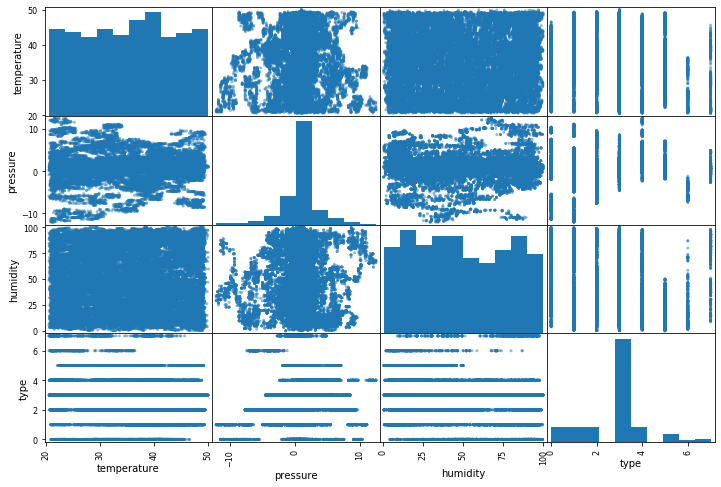

In [20]:
scatter_matrix(weather, figsize=(12, 8))
##The scatter matrices are not very useful, so we will not remove any outliers

In [21]:
##pipeline creation

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
my_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

##Numpy array output 
weather_num = my_pipe.fit_transform(weather)
weather_num.shape

(47408, 4)

In [22]:
##applying the model
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

##prepare for training
x = weather.drop('type', axis = 1)
y = weather['type'].copy()

X =my_pipe.fit_transform(x)

##classifier onj
##n_estimators is number of weak learners to train iteratively
##learning_rate is weight of weak learners
abcWeather= AdaBoostClassifier(n_estimators=50, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
n_scores=cross_val_score(abcWeather, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
print('Accuracy: %3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.229963 (0.067)


In [23]:
##Trying to improve accuracy with turning
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "n_estimators": [100, 250, 500, 1000]}
search=RandomizedSearchCV(abcWeather, param_distributions = parameters, scoring = 'accuracy',
                             cv = 10, verbose = 3, random_state = 40 )

In [25]:
model_adaboost = search.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, learning_rate=0.001, score=0.606, total=  39.6s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.5s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.604, total=  40.2s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.602, total=  42.3s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.608, total=  41.5s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.607, total=  38.8s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.610, total=  41.5s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.606, total=  39.9s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.610, total=  40.8s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.608, total=  41.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................

[CV] . n_estimators=500, learning_rate=0.1, score=0.110, total=  44.1s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.108, total=  44.8s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.112, total=  44.6s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.100, total=  42.8s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.125, total=  42.8s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.113, total=  42.8s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] . n_estimators=500, learning_rate=0.1, score=0.104, total=  42.3s
[CV] n_estimators=500, learning_rate=0.1 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 56.3min finished


In [27]:
abc_final = AdaBoostClassifier(random_state=0, n_estimators=model_adaboost.best_params_['n_estimators'],learning_rate=model_adaboost.best_params_['learning_rate'])
abc_final.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=250, random_state=0)

In [28]:
##predicting response 
X_test = strat_test.drop('type', axis=1)
x_test = my_pipe.fit_transform(X_test)
y_test = strat_test['type'].copy()
y_pred = search.predict(x_test)

In [31]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.37      0.46      0.41      1000
           3       0.64      0.97      0.77      7000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00       573
           6       0.00      0.00      0.00       106
           7       0.00      0.00      0.00       173

    accuracy                           0.61     11852
   macro avg       0.13      0.18      0.15     11852
weighted avg       0.41      0.61      0.49     11852



C:\Users\aradh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
##confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

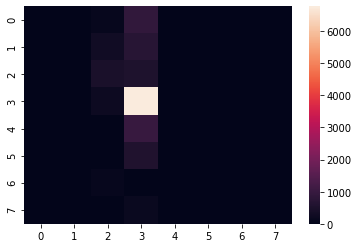

In [30]:
import seaborn as sns 
sns.heatmap(cm)

In [34]:
print(cm)

[[   0    0  117  883    0    0    0    0]
 [   0    0  309  691    0    0    0    0]
 [   0    0  456  544    0    0    0    0]
 [   0    0  234 6766    0    0    0    0]
 [   0    0    8  992    0    0    0    0]
 [   0    0    3  570    0    0    0    0]
 [   0    0  106    0    0    0    0    0]
 [   0    0    5  168    0    0    0    0]]


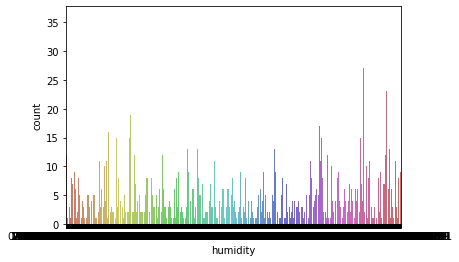

In [36]:
sns.countplot(x='humidity',data=weather, palette='hls')